# CIR Model to simulate changes in Interest Rates and Liability Hedging

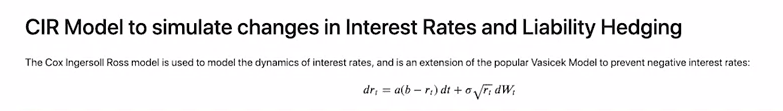 

small change to intest rate that happens at time t is this equation
b-r: where interest rates are today vs. future 
a: how fast do you revert to the long-term interest rate 
b: long-term mean interest rate 

if a == 0: long-term mean rate has no role 
bigger a is, the faster the mean interest rate will revert back to the mean sooner 

The addition of + sigma... - helps eliminate negative interest rates (why it's an extension of the Vasicek Model)

## Short Rate vs. Annualized
Short Rate = instantaneous rate you get for a small amount of time now 

In [30]:
# Get $1 with an interest rate of 100% 
# What do you give back (owe $2):
1 + 1*1

2

In [31]:
1 + 1*.5 + ((1 + 1*.5) *.5)  # if you want to pay 2x per year (compound)

2.25

In [32]:
# if you want to do it 4x per year 
1 + (1) * .25 + \
(1 + (1) * .25)*.25 + \
((1 + (1) * .25)*.25) *.25 + \
(((1 + (1) * .25)*.25) *.25) * .25

1.66015625


__Compound Interest Formula__
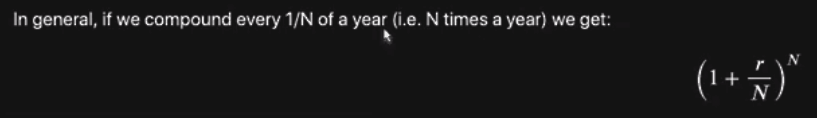

In [33]:
(1+1/2)**2

2.25

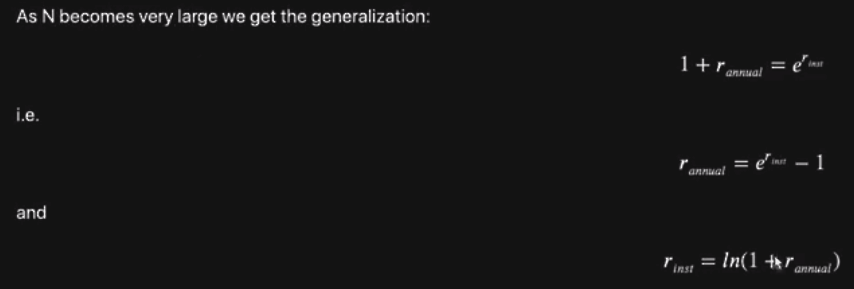

In [34]:
from sys import path 
path.append('../')
import edhec_risk_kit as erk 
    
import pandas as pd 
import numpy as np

import ipywidgets as widgets
from IPython.display import display

%load_ext autoreload 
%autoreload 2

def inst_to_ann(r):
    """
    Converts short rate to an annualized rate 
    """
    #  See formula above 

    # return np.exp(r)-1
    return np.expm1(r)

def ann_to_inst(r):
    """
    Converts annualized rate to a short rate (opposite above)
    """
    # return np.log(1+r)
    return np.log1p(r)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


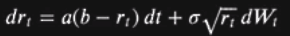

In [35]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR Model for interest rates 
    """

    # if don't give starting interest rate, take b 
    if r_0 is None:
        r_0 = b
    
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year

    # dWt requires generating random numbers 
    num_steps = int(n_years * steps_per_year) + 1  # +1 because we need to start at row 0 
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    
    rates = np.empty_like(shock)  # get array with same dimensions as shock array 
    rates[0] = r_0

    # start simulation 
    for step in range(1, num_steps):
        r_t = rates[step-1]  # rates at the previous step 
        d_r_t = a*(b-r_t) * dt + sigma*np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t)  # should be a positive number (should be especially with shock), to be cautions, add abs()

    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

In [36]:
%matplotlib inline

<Axes: >

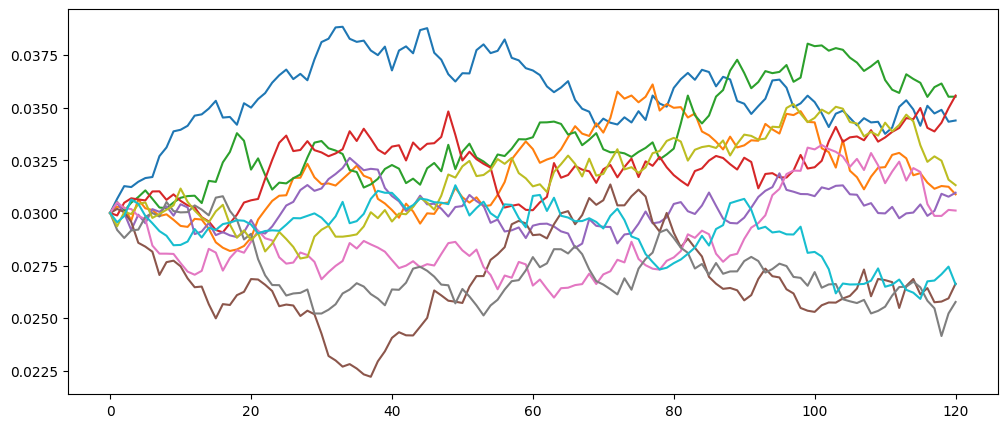

In [37]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

In [38]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [39]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices


In [40]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [41]:
a_0 = .75  # cash on hand (millions)

"""
r_0: Initial interest rate
b: long-term interest rate 
n_scenarios: number of scenarios
"""
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)

# model liabilities as the bond prices - means they are going to change over time 
# liability trying to match is $1m over 10 years 
# the bond is a zero coupon bond - as price of bond (interest rate )


liabilities = bond_prices

So this was unnecessary but why not? We'll leave it like that. Next, what are we going to do? We have the rates, and let's assume for simplicity that I am going to model my liabilities as just the bond prices. So let's look at this. Let's look at what I'm going to do here. Liabilities is nothing more than bond prices.


What that means here is my liabilities are going to change over time, right? Because the idea is, my payoff, my liability that I'm trying to match is one million dollars at the end of my 10 years. But because the bond prices that I am simulating or actually the bond that I'm simulating is actually a zero-coupon bond, then obviously what's going to happen is as the price of that bond changes, the liabilities change appropriately. In other words, as interest rates change, the cost of paying off a dollar is my liability, and the cost of paying off a dollar is also the bond price, and therefore my liabilities are nothing more than the bond prices. Make sense, right? That's the basic little trick that I'm using here, is for me to model my liabilities changing over time, I'm just using nothing more than the changes in the prices of the zero-coupon bond because I know that they're basically the same thing. So now, I can try and figure out what the price of a zero-coupon bond today is.

In [42]:
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(flows=zcbond_10, r=0.03)
n_bonds = a_0 / zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()  # growth of .75 cash * array of rates 

<Axes: >

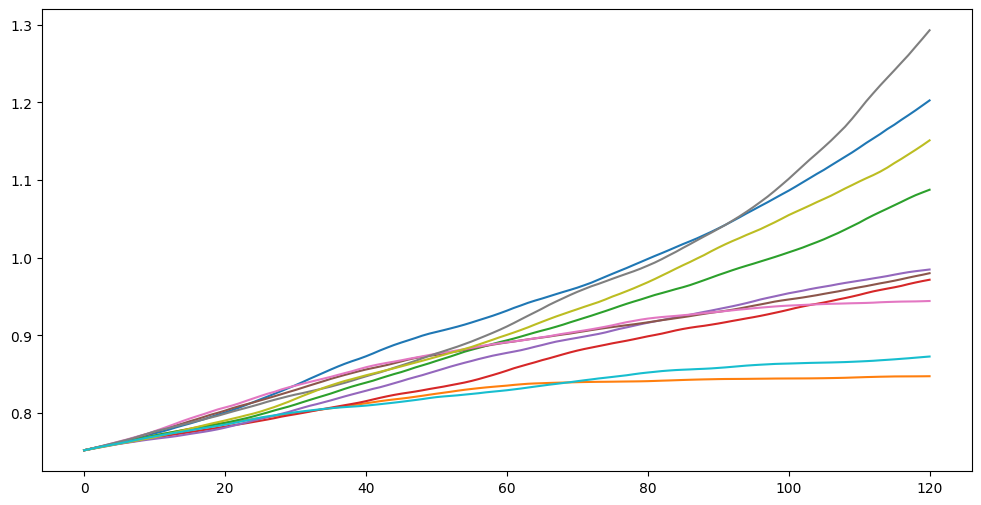

In [43]:
# you can see, if you put your money in cash, it is not a safe hedge because there are scenarios that don't reach $1 million in 10 years (a few do though)
av_cash.plot(legend=False, figsize=(12,6))

<Axes: >

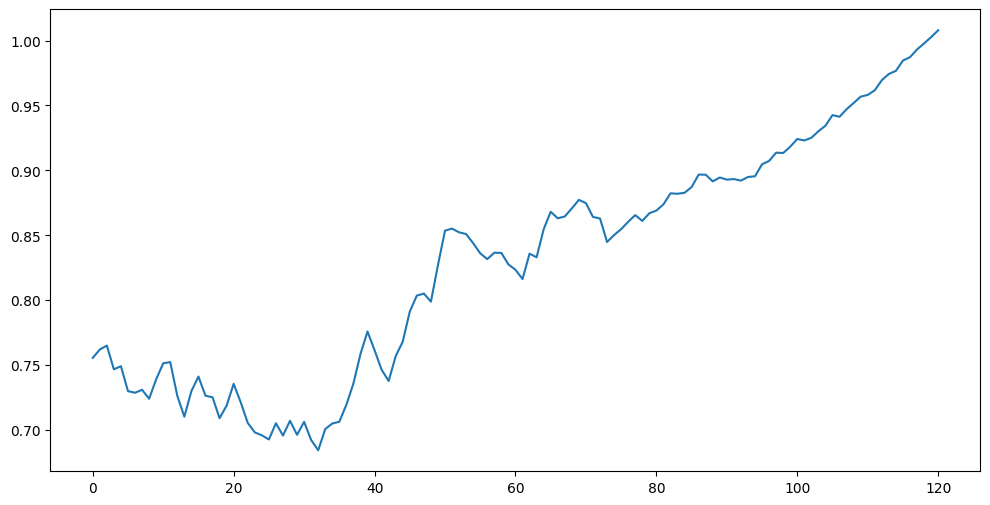

In [44]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

<Axes: title={'center': 'Returns of Funding Ratio with Cash (10 scenarios)'}>

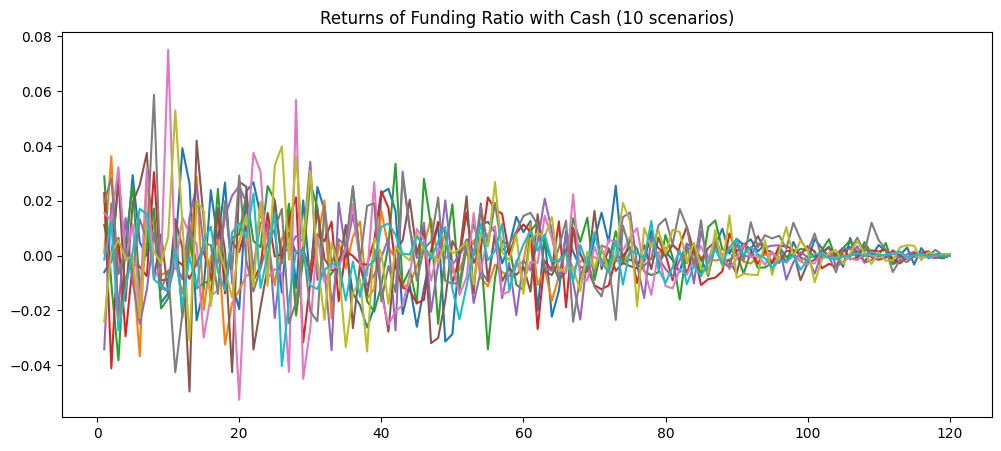

In [46]:
# Funding ratio = av_cash/liabilities 
# How much is this fluctuating by

# cash looks more risky looking at the changes at funding ratios
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns of Funding Ratio with Cash (10 scenarios)'}>

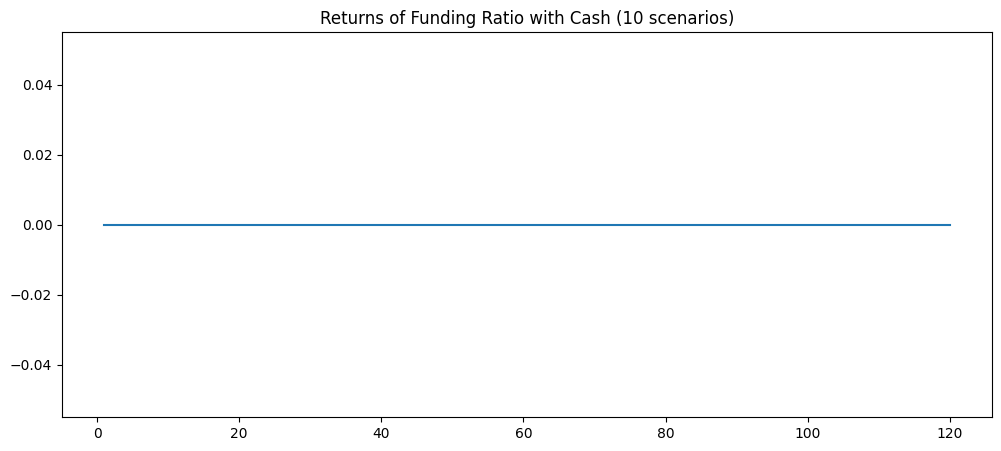

In [47]:
# You want something with a flat funding ratio
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with Bonds (10 scenarios)', legend=False, figsize=(12,5))

In [48]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0 / zc_0
av_zc_bonds = n_bonds*bond_prices 
av_cash = a_0*(rates/12+1).cumprod()


TypeError: Axes.hist() missing 1 required positional argument: 'x'

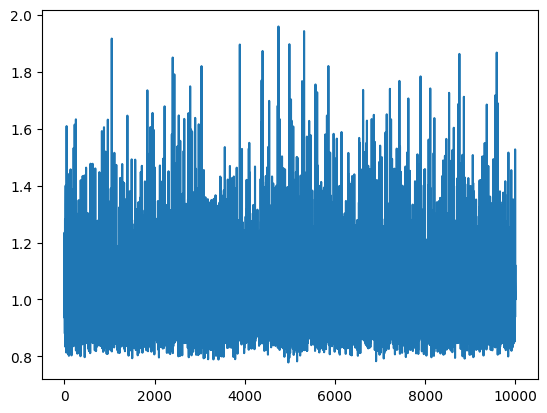

In [53]:
terminal_funding_ratio_cash = av_cash.iloc[-1]/liabilities.iloc[-1]  # -1 = last index 
terminal_funding_ratio_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]

"""
Bug in matplotlib: TypeError: Axes.hist() missing 1 required positional argument: 'x'

"""
ax = terminal_funding_ratio_cash.plot().hist(label='Cash', figsize=(15,6), bins=100, legend=True)
terminal_funding_ratio_bonds.plot().hist(ax=ax, label='ZC Bonds', bins=100, legend=True, secondary_y=True)
